# 64x64 DCGAN experiment

## Importy + mount drive


In [ ]:
# imports
import math # pre 1d funkciu
import numpy as np
import tensorflow.keras.backend as k_backend
from tensorflow.keras.models import Sequential, load_model
# from keras.optimizers import *
from tensorflow.keras.layers import Dense, \
                         Conv2D, \
                         LeakyReLU, \
                         Dropout, \
                         Flatten, \
                         Reshape, \
                         Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.config import list_physical_devices

from tensorflow.keras import initializers, optimizers
from matplotlib import pyplot as plt
# from tensorflow_datasets.image import CelebA
from skimage.transform import resize
import random
from PIL import Image
import datetime # testing


In [ ]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  output_path = "/content/drive/My Drive/gan_files"

KeyboardInterrupt: ignored

## Stiahnutie Flickr-Faces-HQ datasetu
Možnosť A: Stiahnuť dataset nanovo - veľká pravdepodobnosť vyčerpania download kvóty

Možnosť B: Načítať pred-pripravený zip súbor s datasetom 

In [2]:
# A
%cd /content/
!git clone https://github.com/NVlabs/ffhq-dataset.git
%cd ffhq-dataset
!python download_ffhq.py --thumbs

/content
Cloning into 'ffhq-dataset'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 64 (delta 0), reused 1 (delta 0), pack-reused 60
Unpacking objects: 100% (64/64), done.
/content/ffhq-dataset
\ 100.00% done  2/2 files  0.25/0.25 GB   74.97 MB/s  ETA: done    
Parsing JSON metadata...
Traceback (most recent call last):
  File "download_ffhq.py", line 445, in <module>
    run_cmdline(sys.argv)
  File "download_ffhq.py", line 440, in run_cmdline
    run(**vars(args))
  File "download_ffhq.py", line 391, in run
    json_data = json.load(f, object_pairs_hook=OrderedDict)
  File "/usr/lib/python3.7/json/__init__.py", line 296, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.7/json/__init__.py", line 361, in loads
    return cls(**kw).decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.ra

In [ ]:
# B
!mkdir /content/ffhq-dataset
!unzip "/content/drive/MyDrive/ffhq_dataset_thumbs/dataset_download.zip" -d "/content/ffhq-dataset"

In [ ]:
# povinné metadata o datasete
dataset_path = '/content/ffhq-dataset/thumbnails128x128'
dataset_size = 70000

/content/training


## Definície modelov, funkcií - TODO presuň do .py súborov, real sample dict + predeterined samples daj do sep. bunky

In [ ]:
# definicie modelu
default_width = 64
default_height = 64
default_dims = 100
pixel_depth = 3 #rgb

model_type = '0_to_1_leakyReLU_tanh_x64'

In [ ]:
real_sample_dict = {}

def rgb_to_float(rgb_value):
    zero_to_one = rgb_value / 256.0
    # normalized = (zero_to_one - 0.5) * 2
    return zero_to_one


def float_to_rgb(float_value):
    # converted_float = (float_value / 2) + 0.5
    rgb_value = (float_value * 256)
    rgb_value = np.where(rgb_value > 255, 255, rgb_value)
    rgb_value = np.where(rgb_value < 0, 0, rgb_value).astype('uint8')
    return rgb_value


def generate_real_samples(i_start, n):
    picked_sample_list = list()
    for i_image in range(i_start, i_start + n):
        chosen_sample = i_image
        
        if chosen_sample not in real_sample_dict:
            chosen_folder = chosen_sample - (chosen_sample % 1000)
            
            folder_string = str(chosen_folder)
            image_string = str(chosen_sample)
            folder_string = folder_string.rjust(5,'0') #padding
            image_string = image_string.rjust(5,'0') #padding   
            
            full_path = dataset_path + '/' + folder_string + '/' + image_string + '.png'
            
            with Image.open(full_path) as image:
                image_array = np.array(image)
            image_array = resize(image_array, (default_height, default_width))
            
            real_sample_dict[chosen_sample] = image_array
            
        else:
            image_array = real_sample_dict[chosen_sample]
        picked_sample_list.append(image_array)
    
    # po nacitani n-vzoriek:
    X = np.array(picked_sample_list) #.reshape(n, 1)
    y = np.ones((n, 1))
    return X, y   
    # print(image_array)


def generate_real_samples_random(n, i_min=0, i_max=dataset_size):
    picked_sample_list = list()
    for i_image in range(n):
        chosen_sample = random.choice(range(i_min,i_max))
        #print(i_image, 'chose image', chosen_sample)
        
        if chosen_sample not in real_sample_dict:
            chosen_folder = chosen_sample - (chosen_sample % 1000)
            
            folder_string = str(chosen_folder)
            image_string = str(chosen_sample)
            folder_string = folder_string.rjust(5,'0') #padding
            image_string = image_string.rjust(5,'0') #padding   
            
            full_path = dataset_path + '/' + folder_string + '/' + image_string + '.png'
            
            with Image.open(full_path) as image:
                image_array = np.array(image)
            image_array = resize(image_array, (default_height, default_width))
            
            real_sample_dict[chosen_sample] = image_array
            
        else:
            image_array = real_sample_dict[chosen_sample]
        picked_sample_list.append(image_array)
    
    # po nacitani n-vzoriek:
    X = np.array(picked_sample_list) #.reshape(n, 1)
    y = np.ones((n, 1))
    return X, y   
    # print(image_array)


def generate_noise_samples(n):
    samples = list()
    for i_sample in range(n):
        random_array = np.random.randint(0, high=255, size=default_height * default_width * pixel_depth)
        random_array = random_array.reshape(default_height, default_width, pixel_depth)
        samples.append(random_array)
    X = np.array(samples) #.reshape(n, (default_height, default_width, pixel_depth))
    y = np.zeros((n, 1))
    return X,y


def random_latent_points(n_dim, n):
    latent_vectors = np.random.randn(n_dim * n) # n čísel z gauss. distrib.
    latent_vectors = latent_vectors.reshape(n, n_dim)
    return latent_vectors

def generate_fake_samples(generator, x_input, n_dim, n): # [-1,1]
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y

def train_discriminator_noise(model, n_iter=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    
    for i in range(n_iter):
        X_real, y_real = generate_real_samples_random(half_batch)
        X_real = rgb_to_float(X_real.astype('float32'))
        model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_noise_samples(half_batch)
        X_fake = rgb_to_float(X_fake.astype('float32'))
        model.train_on_batch(X_fake, y_fake)
        
        _, accuracy_real = model.evaluate(X_real, y_real, verbose=0)
        _, accuracy_fake = model.evaluate(X_fake, y_fake, verbose=0)
        
        print(i, '\nReal', accuracy_real, '\nFake', accuracy_fake)

p_dims = 100
p_n = 100
predetermined_inputs = np.random.randn(p_dims * p_n) # n vektorov z gauss. distrib.
predetermined_inputs = predetermined_inputs.reshape(p_n, p_dims)


    
    
def eval_performance(gan_model, generator, discriminator, losses, metadata_list, init_time,
                     n_dim, i_epoch, n_epochs, i_batch, n_batches, n=25, n_plot=10, plot_size=9):
    
    x_real, y_real = generate_real_samples_random(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    input_points = random_latent_points(n_dim, n)
    x_fake, y_fake = generate_fake_samples(generator, input_points, n_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    time_taken = datetime.datetime.now() - init_time
    
    eval_string = f'''[Epoch {i_epoch}/{n_epochs}, Batch {i_batch}/{n_batches}]
    Time since start: {time_taken}
    Disc. loss real: {losses[0]}
    Disc. loss fake: {losses[1]}
    Gen. loss: {losses[2]}
    Acc. real: {acc_real}
    Acc. fake: {acc_fake} (of {n} samples)
    '''
    
    with open(f'{output_path}/{model_type}/outputs/evaluation/epoch_metadata.txt', 'a+') as metadata_file:
        metadata_file.write(eval_string)
    print(eval_string)
    
    metadata_list.append(
        [
        time_taken.seconds / 3600, # float hodnota kolko hodin od startu
        losses[0],
        losses[1],
        losses[2],
        acc_real,
        acc_fake
        ]
    )
    
    if i_batch % n_plot == 0:
        # n_factor = math.sqrt(n)
        inputs = predetermined_inputs
        fig = generate_and_plot(generator, n_dim, inputs, plot_size)
        epoch_padding_size = 8#len(str(n_epochs-1))
        batch_padding_size = 8#len(str(n_batches-1))
        filename = f"{output_path}/{model_type}/outputs/output_epoch_{str(i_epoch).rjust(epoch_padding_size,'0')}_{str(i_batch).rjust(batch_padding_size,'0')}.png"
        fig.savefig(filename)
        plt.show(fig)
        plt.close(fig)
        #input_points = random_latent_points(n_dim, n_factor * n_factor)
        #x_plt, _ = generate_fake_samples(generator, predetermined_inputs, n_dim, n_factor * n_factor)
        #padding_size = len(str(n_epochs-1))
        #fig = plt.figure(figsize=(n_factor*1.5, n_factor*1.5))
        #plt.text(0.5,-0.15,
        #f'''[Epoch {i_epoch}/{n_epochs}] Time since start: {datetime.datetime.now() - init_time}
        #Disc. loss real: {round(losses[0], 4)}, Disc. loss fake: {round(losses[1], 4)}, Gen. loss: {round(losses[2], 4)}
        #Acc. real: {round(acc_real, 4)}, Acc. fake: {round(acc_fake, 4)} (of {n} samples)
        #''',
        #         horizontalalignment='center')
        #
        #fig.subplots_adjust(wspace=1/default_width, 
        #                    hspace=1/default_height
        #                    )
        #for i in range(n_factor * n_factor):
        #    if i == 0:
        #        print(x_plt[i, default_height//2, default_width//2], '\n', ((x_plt[i, default_height//2, default_width//2]/2 + 0.5)*256).astype('int'))
        #    
        #    # define subplot
        #    ax = fig.add_subplot(n_factor, n_factor, 1 + i)
        #    plt.axis('off')
        #    ax.imshow(float_to_rgb(x_plt)[i], interpolation='nearest')
        #
        #filename = f"{output_path}/{model_type}/outputs/generator_epoch_{str(i_epoch).rjust(padding_size,'0')}.png"
        #fig.savefig(filename)
        #plt.show()
        #plt.close(fig)
        
        
def train_gan(gan_model, generator, discriminator, metadata_list,
              n_dim=100, start_epoch=0, n_epochs=100, n_batch=128, n_eval=2000, eval_samples=64, n_plot=10, plot_size=9):
    # diskriminator updatujeme so vstupmi v pocte n_batch, pol. real, pol. fake
    half_batch = n_batch // 2
    batches = dataset_size // half_batch
    
    init_time = datetime.datetime.now()
    
    for epoch in range(from_epoch, n_epochs):
        start_n = 0  # pozicia v datasete pre epoch
        for i in range(batches):
            print(f"[Epoch {epoch}] Batch {i}/{batches}")
          
            # vstup a target pre diskriminator
            x_real, y_real = generate_real_samples(start_n, half_batch)
            input_points = random_latent_points(n_dim, half_batch)
            x_fake, y_fake = generate_fake_samples(generator, input_points, n_dim, half_batch)
            
            d_loss_real, _ = discriminator.train_on_batch(x_real, y_real)
            d_loss_fake, _ = discriminator.train_on_batch(x_fake, y_fake)
            
            # vstup a target pre generator
            x_gan = random_latent_points(n_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(x_gan, y_gan)
            
            if i % n_eval == 0:
                losses = (d_loss_real, d_loss_fake, g_loss)
                eval_performance(gan_model, generator, discriminator, losses, metadata_list, init_time,
                                n_dim, epoch, n_epochs, i, batches, n=eval_samples, n_plot=n_plot, plot_size=plot_size)
            
            start_n += half_batch;
              

            
def show_dataset():
    x_plt, _ = generate_real_samples_random(16)
    n_factor = 3 # 4x4
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(n_factor * n_factor): # ZMEN ABY NAMIESTO 4,5 BOLI FACTORS
        # define subplot
        ax = fig.add_subplot(n_factor, n_factor, 1 + i)
        plt.axis('off')
        ax.imshow(x_plt[i], interpolation='nearest')
    plt.show()
    plt.close(fig)
    
def generate_and_plot(generator, n_dim, inputs, n):
    n_factor = int(math.sqrt(n))
    x_plt, _ = generate_fake_samples(generator, inputs, n_dim, n)
    
    px = 1/plt.rcParams['figure.dpi']
    fig = plt.figure(frameon=False, figsize=((n_factor*default_width)*px, (n_factor*default_height)*px))
    
    for i in range(n_factor * n_factor): # ZMEN ABY NAMIESTO 4,5 BOLI FACTORS
        # define subplot
        ax = fig.add_subplot(n_factor, n_factor, 1 + i)
        ax.axis('off')
        ax.imshow(float_to_rgb(x_plt)[i], interpolation='nearest')
    plt.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    return fig


def latent_transition(pointA, pointB, n_dim=100, n_steps=100):
    transition_points = np.empty([n_steps, n_dim])
    
    for i in range(n_dim): # for each latent dim
        #generate a transition between A and B on this dim
        dim_transition = np.linspace(pointA[i], pointB[i], n_steps)
        for step in range(n_steps): #then assign each step of transition properly to the final array
            transition_points[step][i] = dim_transition[step]
        
    return transition_points
        

## Vytvorenie modelu

In [ ]:
show_dataset() # realne vzorky z datasetu v aktualne zvolenom rozliseni

generator = make_generator()
discriminator = make_discriminator()
gan = make_gan_model(generator, discriminator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## TODO tieto metadata ukladaj, zapisuj do metadata list index z batch namiesto času v hod.

In [ ]:
open(f'{output_path}/{model_type}/outputs/evaluation/epoch_metadata.txt', 'w').close()

In [ ]:
metadata_list = []

## Trénovací proces

In [ ]:
from_epoch = 10
to_epoch = 12

a = datetime.datetime.now()

train_gan(gan, generator, discriminator, metadata_list,
          n_dim=100, start_epoch=from_epoch, n_epochs=to_epoch, 
          n_batch=dataset_size//700, n_eval=10, eval_samples=100, n_plot=50, plot_size=9)

b = datetime.datetime.now()
print("Time taken: ", b - a)

generator.save_weights(f"{output_path}/{model_type}/saves/generator_{to_epoch}.hdf5", overwrite=True)
discriminator.save_weights(f"{output_path}/{model_type}/saves/discriminator_{to_epoch}.hdf5", overwrite=True)

Načítať uložené weights podľa epochy

In [ ]:
load_epoch = 10

generator.load_weights(f"{output_path}/{model_type}/saves/generator_{load_epoch}.hdf5")
discriminator.load_weights(f"{output_path}/{model_type}/saves/discriminator_{load_epoch}.hdf5")

## Vyhodnotenie trénovania - TODO

In [ ]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

def Extract(lst, index):
    return [item[index] for item in lst]

fig = plt.figure()
fig, axs = plt.subplots(2)
p1 = axs[0].plot(Extract(metadata_list,0), Extract(metadata_list,1), 'r-o', label='Disc. loss real')
p2 = axs[0].plot(Extract(metadata_list,0), Extract(metadata_list,2), 'g-o', label='Disc. loss fake')
p3 = axs[0].plot(Extract(metadata_list,0), Extract(metadata_list,3), 'b-o', label='Gen. loss')

p4 = axs[1].plot(Extract(metadata_list,0), Extract(metadata_list,4), 'k-o', label='Acc. real')
p5 = axs[1].plot(Extract(metadata_list,0), Extract(metadata_list,5), 'm-o', label='Acc. fake')

axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")

fig.set_size_inches(18.5, 10.5)

plt.show()
plt.close(fig)

with open("SAVEDLIST.txt") as listfile:
    listfile.write()
# print(metadata_list)

## Koláž výstupov generátora

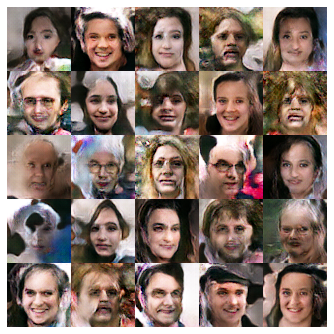

In [ ]:
fig = generate_and_plot(generator, 100, predetermined_inputs, 25)
plt.show(fig)

## Náhľad do vnútorných vrstiev generátora - filter po filtri

In [ ]:
get_all_layer_outputs = k_backend.function([generator.layers[0].input],
                                  [l.output for l in generator.layers[2:-1]])

latent_p = predetermined_inputs[:10]
layer_output = get_all_layer_outputs(latent_p) # return the same thing
for output in layer_output:
  print(output.shape)
  rgb = np.hstack((float_to_rgb(output[0, :, :, i]) for i in range(10)))
  print(rgb.shape)
  plt.imshow(rgb)
  plt.show()
plt.close()

## Plynulý prechod medzi dvoma vzorkami - TODO animovať

In [ ]:
pointA = predetermined_inputs[24]
pointB = predetermined_inputs[35]
transition = latent_transition(pointA, pointB, n_dim=100, n_steps=100)
input_points = random_latent_points(100, 10)
print(transition.shape)

fig = generate_and_plot(generator, 100, transition, 100)
# fig = generate_and_animate(generator, 100, transition, 25)
plt.show(fig)

# for transition_sample in transition:
#     transition_sample = transition_sample.reshape(1,100)
#     X,_ = generate_fake_samples(generator, transition_sample, 100, 1)
#     plt.axis('off')
#     plt.imshow(float_to_rgb(X[0]))
#     plt.show()
#     plt.close()